In week 3's final notebook, we will train classifiers on real [wildfire](https://en.wikipedia.org/wiki/Wildfire) data to map the fire risk in different regions of Italy. To keep the data size manageable, we will focus on the coastal [Liguria region](https://en.wikipedia.org/wiki/Liguria) that experiences a lot of wildfires, especially during the winter. 



---



**Credits**

This online tutorial would not be possible without invaluable contributions from [Andrea Trucchia](https://www.researchgate.net/profile/Andrea-Trucchia) (reduced data, methods), [Giorgio Meschi](https://www.linkedin.com/in/giorgio-meschi-86216b180/) (code, methods), and [Marj Tonini](https://www.researchgate.net/profile/Marj-Tonini-2) (presentation, methods). The methodology builds upon the following article:

[Trucchia, A.; Meschi, G.; Fiorucci, P.; Gollini, A.; Negro, D., Defining Wildfire Susceptibility Maps in Italy for Understanding Seasonal Wildfire Regimes at the National Level, *Fire*, (2022)](https://www.mdpi.com/2571-6255/5/1/30) 

which generalizes the study below from the Liguria region (our case study) to all of Italy:

[Tonini, Marj, et al. "A machine learning-based approach for wildfire susceptibility mapping. The case study of the Liguria region in Italy." *Geosciences* 10.3 (2020): 105.](https://www.mdpi.com/2076-3263/10/3/105)



---



# Exercise 4: Mapping Wildfire Susceptibility in the Liguria Region with Simple Machine Learning Classifiers

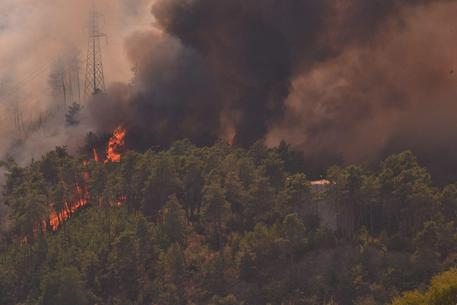

**Caption**: A wildfire in Italy. Can we predict which locations are most susceptible to wildfires using simple classifiers? 🔥

**Source**: [ANSA](https://www.ansa.it/english/news/2015/08/14/wildfires-in-italy-up-120-this-summer-on-past-two-years_f6e4eff7-ac07-4f9e-aa5a-e61f8c2ad7f2.html)

Let's start by downloading and loading the datasets into memory using the [`pooch`](https://pypi.org/project/pooch/), [`pickle5`](https://pypi.org/project/pickle5/), and [`GeoPandas`](https://geopandas.org/en/stable/) libraries:

In [4]:
# Install geopandas and pickle5
%pip install geopandas
%pip install pickle5

     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 16.7 MB 318 kB/s 
     |████████████████████████████████| 6.3 MB 22.1 MB/s 
     |████████████████████████████████| 256 kB 5.1 MB/s 


In [5]:
import geopandas as gpd
import numpy as np
import pickle5 as pickle
import pooch

In [3]:
# Function to load the data
def load_data(path):
    
    # Load the content of the pickle file (using pickle5 for Google Colab)
    with open(path, "rb") as fh:
        points_df = pickle.load(fh)

    # Convert it to a Geopandas `GeoDataFrame` for spatial analysis
    points_df = gpd.GeoDataFrame(points_df, 
                                 geometry=gpd.points_from_xy(np.float64(points_df.x), 
                                                             np.float64(points_df.y))) 
    return points_df

In [6]:
# Path to the data in UNIL OneDrive
variables_path = pooch.retrieve('https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EU4FQkuYknFDiDfd7droyAcBP0qFOR5-c-_Oq74gjhTGwQ?download=1',
                            known_hash='e8ebc70f972b5af4ef3d6110dcd61ce01ce5a830dcdb7d2c9e737aeab781606c')
wildfires_path = pooch.retrieve('https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/EcjqeERsnIRHjhcx1ZFVNggBS7nPUkW530XRrpVUB-qnOw?download=1',
                             known_hash='361f067aafbac8add8f8a9a5c630df3c962cd37a2f125f420e7b9330fd0a1a4c')

In [7]:
# Load the data and convert it to a GeoPandas `GeoDataFrame`
# This can take a minute
variables = load_data(variables_path)
wildfires = load_data(wildfires_path)

In [ ]:
wildfires.head(2)

,geometry,x,y,fire_index,season
point_index,,,,,
1761,POINT (1500504.192 4943934.406),1.500504e+06,4.943934e+06,1761.0,2
1851,POINT (1500504.192 4943834.406),1.500504e+06,4.943834e+06,1851.0,2


## Part I: Pre-Processing the Dataset for Classification

**Q1) After analyzing the topography and land cover data provided in `variables`, create your input dataset `inputs` from `variables` to predict the occurence of wildfires (`wildfires`). Keep at least one categorical variable (`veg`, `bioclim`, or `phytoclim`).**

Hint 1: Refer to the documentation [at this link](https://unils-my.sharepoint.com/:t:/g/personal/tom_beucler_unil_ch/EREf92h-43VBtgPjwveMfrQBRahitmHxBKAtNx04lleh7Q?e=Fx6nad) to know what the different `keys` of `variables` refer to.

Hint 2: You may refer to Table 1 of [Tonini et al.](https://www.mdpi.com/2076-3263/10/3/105), copied below, to choose your input variables, although we recommend starting with less inputs at first to build a simpler model and avoid overfitting.

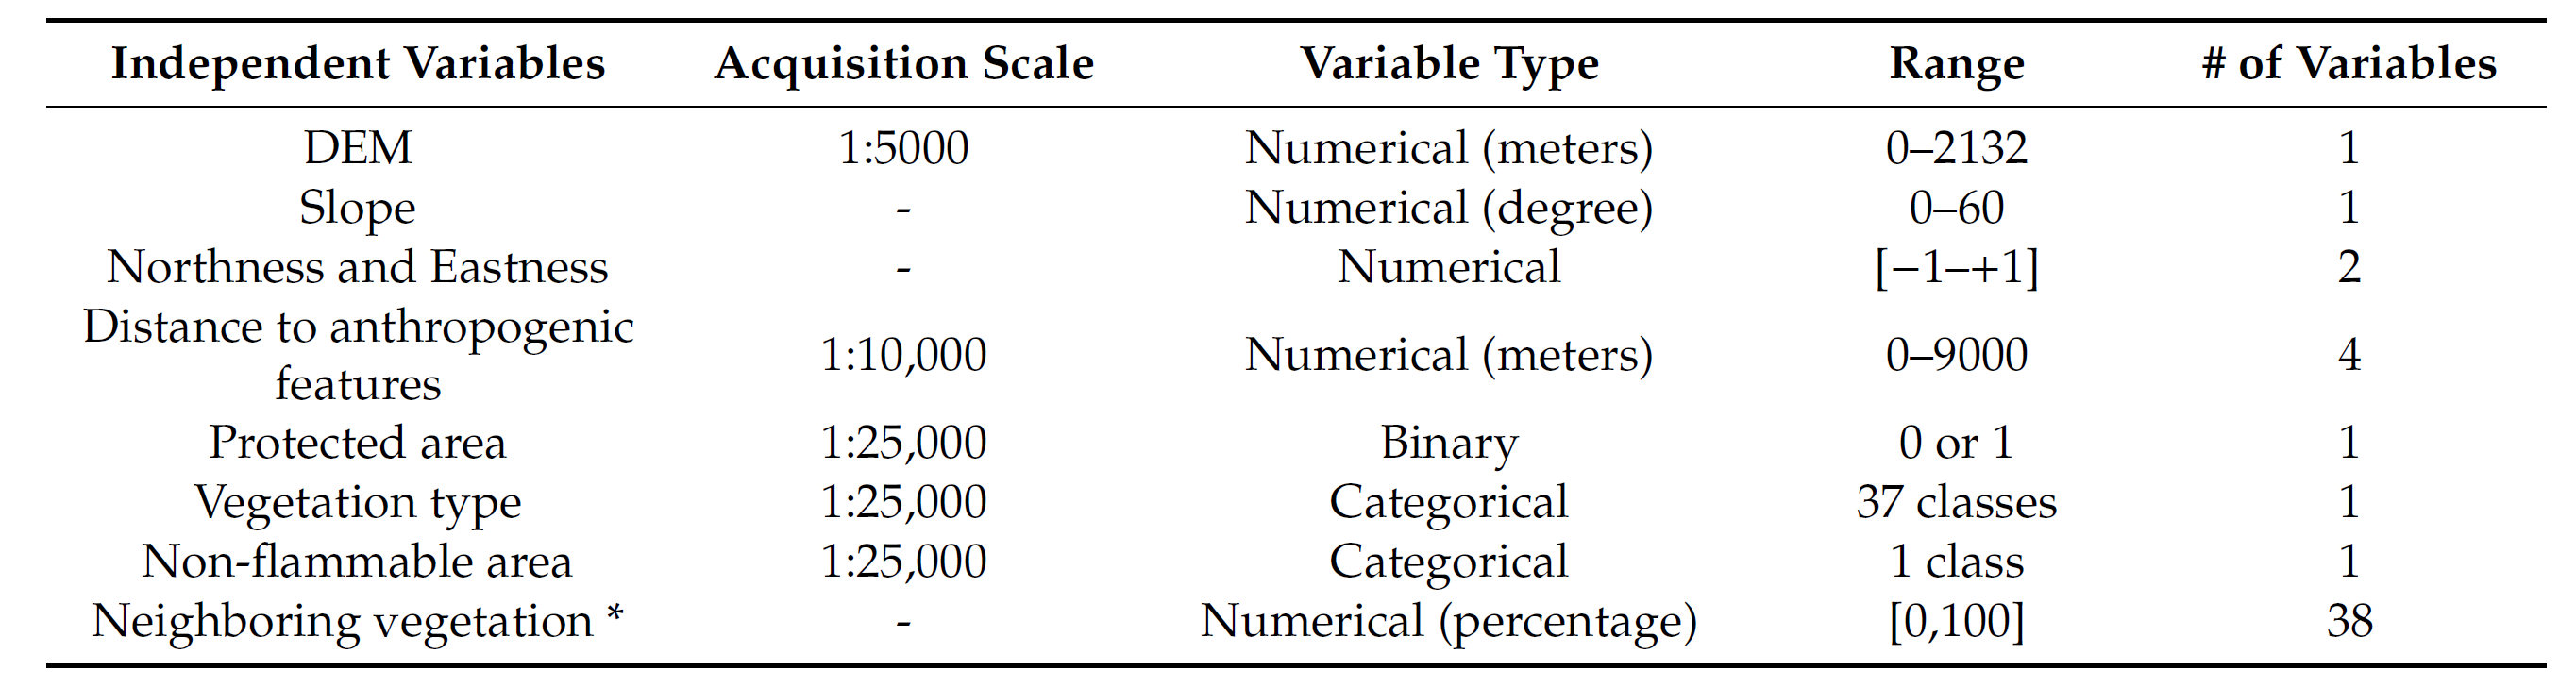

In [8]:
# Explore the `variables` dataset
variables.columns

Index(['row', 'col', 'x', 'y', 'dem', 'slope', 'north', 'east', 'veg',
       'urban_d', 'roads_d', 'crops_d', 'tracks_d', 'bioclim', 'phytoclim',
       'temp_1', 'temp_2', 'prec_1', 'prec_2', 'perc_0', 'perc_21', 'perc_22',
       'perc_23', 'perc_32', 'perc_33', 'perc_34', 'perc_37', 'point_index',
       'geometry'],
      dtype='object')

In [9]:
# Select the inputs you would like to keep

variables[['dem','veg','slope','bioclim']]

,dem,veg,slope,bioclim
point_index,,,,
0,563,34,20.843185,15
1,527,34,23.599121,15
2,525,34,26.699856,15
3,519,34,24.512413,15
4,532,34,20.421495,15
...,...,...,...,...
519336,125,37,29.669502,0
519386,139,32,23.541714,0
519388,113,32,16.290375,0


In [10]:
# Form the `inputs` dataset

inputs = variables[['dem','veg','slope']]
inputs

,dem,veg,slope
point_index,,,
0,563,34,20.843185
1,527,34,23.599121
2,525,34,26.699856
3,519,34,24.512413
4,532,34,20.421495
...,...,...,...
519336,125,37,29.669502
519386,139,32,23.541714
519388,113,32,16.290375


**Q2) To avoid making inaccurate assumptions about which types of vegetation and non-flammable area are most similar, convert your categorical inputs into one-hot vectors.**

Hint 1: You may use the [`fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder.fit_transform) method of `scikit-learn`'s [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) class to convert categorical inputs into one-hot vectors.

Hint 2: Don't forget to remove the categorical variables from your input dataset, e.g. using [`drop`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) if you are still using a `GeoDataFrame`, or [`del`](https://docs.python.org/3/reference/simple_stmts.html#the-del-statement)/[`pop`](https://docs.python.org/3/library/stdtypes.html#dict.pop) if you are working with a Python dictionary. 

In [11]:
# Import the necessary classes and functions
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [12]:
# Convert your categorical inputs into one-hot vectors
import pandas as pd

transformed = OHE.fit_transform(inputs.veg.to_numpy().reshape(-1, 1))

In [13]:
# Don't forget to add your one-hot vectors to your `inputs`

ohe_df = pd.DataFrame(transformed, columns=OHE.get_feature_names_out())
ohe_df

,x0_21,x0_22,x0_23,x0_32,x0_33,x0_34,x0_37
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
528664,0.0,0.0,0.0,0.0,0.0,0.0,1.0
528665,0.0,0.0,0.0,1.0,0.0,0.0,0.0
528666,0.0,0.0,0.0,1.0,0.0,0.0,0.0
528667,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
# and to delete your categorical variables from your `inputs`
variables = pd.merge(inputs,ohe_df,left_index=True, right_index=True).drop('veg', axis= 1)
variables

,dem,slope,x0_21,x0_22,x0_23,x0_32,x0_33,x0_34,x0_37
0,563,20.843185,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,527,23.599121,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,525,26.699856,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,519,24.512413,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,532,20.421495,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
519467,78,18.016613,0.0,1.0,0.0,0.0,0.0,0.0,0.0
519468,48,22.538818,0.0,1.0,0.0,0.0,0.0,0.0,0.0
519469,16,7.200756,0.0,0.0,1.0,0.0,0.0,0.0,0.0
519470,54,15.985183,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Now that we built our `inputs` dataset, we are ready to build our `outputs` dataset!

**Q3) Using the `point_index` column of `wildfires` and `variables`, create your `outputs` dataset, containing 1 when there was a wildfire and 0 otherwise.**

Hint: Check that `inputs` and `outputs` have the same number of cases by looking at their `.shape[0]` attribute. 

In [15]:
# Initialize your `outputs` dataset using the `variables` dataset
variables['output'] = 0
variables

,dem,slope,x0_21,x0_22,x0_23,x0_32,x0_33,x0_34,x0_37,output
0,563,20.843185,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,527,23.599121,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,525,26.699856,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,519,24.512413,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,532,20.421495,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
519467,78,18.016613,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
519468,48,22.538818,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
519469,16,7.200756,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
519470,54,15.985183,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [16]:
# Fill it with 0 and 1 using the `wildfire` dataset
for i in range(len(wildfires)):
    variables.output[wildfires.index[i]] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
variables

,dem,slope,x0_21,x0_22,x0_23,x0_32,x0_33,x0_34,x0_37,output
0,563,20.843185,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,527,23.599121,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,525,26.699856,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,519,24.512413,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,532,20.421495,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
519467,78,18.016613,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
519468,48,22.538818,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
519469,16,7.200756,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
519470,54,15.985183,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [17]:
# Check that `inputs` and `outputs` have the same shape[0]
output = variables[['output']]
variables.drop('output', axis = 1, inplace= True)
variables
variables.shape[0] == output.shape[0]

True

**Q4) Separate your `inputs` and `outputs` datasets into a training and a test set. Keep at least 20% of the dataset for testing.** 

Hint 1: You may use `scikit-learn`'s [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

Hint 2: If you are considering optimizing the hyperparameters of your classifier, form a validation dataset as well.

In [18]:
# Import the necessary classes and functions
from sklearn.model_selection import train_test_split
X = variables
y= output

In [26]:
# Split your `inputs`/`outputs` datasets into training(/validation)/test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [ ]:
X_train.shape

(422935, 9)

In [27]:
# Check the shape of your training(/validation)/test sets
# and make sure you kept at least 20% of your dataset for testing
(X_train.shape, X_test.shape, X_val.shape)



((338348, 9), (105734, 9), (84587, 9))

In [28]:
(y_train.shape, y_test.shape, y_val.shape)

((338348, 1), (105734, 1), (84587, 1))

Congratulations, you have created a viable wildfire dataset to train a machine learning classifier! 😃 Now let's get started 🔥

<a name="previous_ex"></a>
## Part II: Training and Benchmarking the Machine Learning Classifiers

**Q5) Now comes the machine learning fun! 🤖 Train multiple classifiers on your newly-formed training set, and make sure that at least one has the `predict_proba` method once trained.**

Hint: You may train a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) or an [`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), but we encourage you to be creative and include additional classifiers you find promising! 💻

In [60]:
# Import the necessary classes and functions
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

RF = RandomForestClassifier()
ET = ExtraTreesClassifier()
LR =  LogisticRegression(solver='lbfgs', max_iter=1000) #solver='lbfgs', max_iter=10000
KN = KNeighborsClassifier() 
DT = DecisionTreeClassifier()

In [61]:
# Train the classifiers on the training set
models = (RF,ET,LR,KN,DT)

for model in models:
    model.fit(X_train,y_train.values.ravel())
    print(f'{model} fit done')

RandomForestClassifier() fit done
ExtraTreesClassifier() fit done
LogisticRegression(max_iter=1000) fit done
KNeighborsClassifier() fit done
DecisionTreeClassifier() fit done


In [34]:
# (Optional) Conduct a hyperparameter search on the validation set
# e.g., using scikit-learn's RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [52]:
# Random forest
RF = RandomForestClassifier(n_jobs=-1, random_state=12, max_features='auto', 
                             oob_score=True, criterion='gini')
### Hyperparametes space
n_estimators = np.arange(100, 2000, step=100)
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(10, 100, step=10)) + [None]
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]

param_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
}



RF_cv = RandomizedSearchCV(
    RF, param_grid, n_iter=100, cv=5, scoring="r2", n_jobs=-1
)

RF_cv.fit(X_train,y_train) #[(X_train, y_train), (X_val, y_val)])

In [ ]:
print(RF_cv.best_score_)
print(RF_cv.best_params_)

**Q6) Compare the performance and confusion matrices of your classifiers on the test set. Which classifier performs best in your case?** 

Hint 1: You may use the [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) to quantify your classifier's performance, but don't forget there are [many other performance metrics to benchmark binary classifiers](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics). 

Hint 2: You can directly calculate the confusion matrix using `scikit-learn`'s [`confusion_matrix` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). 

In [67]:
# Import the necessary classes and functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [62]:
# Calculate the prediction of your classifier(s) over your test set
RF_pred = RF.predict(X_test)
ET_pred = ET.predict(X_test)
LR_pred = LR.predict(X_test)
KN_pred = KN.predict(X_test)
DT_pred = DT.predict(X_test)


In [71]:
# Infer their performance

predictions = (RF_pred,ET_pred,LR_pred,KN_pred,DT_pred)

for p in predictions:
  accuracy = accuracy_score(y_test, p)
  print(f'The accuracy of the model each model is {accuracy:.1%}')

The accuracy of the model each model is 84.1%
The accuracy of the model each model is 83.1%
The accuracy of the model each model is 84.3%
The accuracy of the model each model is 82.9%
The accuracy of the model each model is 78.0%


In [96]:
# and their confusion matrices
from sklearn.metrics import plot_confusion_matrix
# RF
confusion_matrix(y_test,RF_pred)



array([[84550,  4730],
       [12056,  4398]])

In [97]:
#ET_pred
confusion_matrix(y_test,ET_pred)


array([[83451,  5829],
       [11992,  4462]])

In [98]:
#'LR_pred'
confusion_matrix(y_test,LR_pred)

array([[88886,   394],
       [16172,   282]])

In [100]:
#'KN'
confusion_matrix(y_test,KN_pred)


array([[85185,  4095],
       [14000,  2454]])

In [101]:
#'DF'
confusion_matrix(y_test,DT_pred)

array([[76908, 12372],
       [10866,  5588]])

For comparison, below is the confusion matrix obtained by the paper's authors:


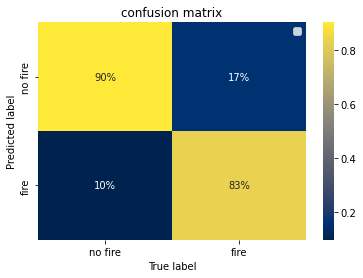

## Part III: Making the Susceptibility Map

**Q7) Using all the classifiers you trained that have a `predict_proba` method, predict the probability of a wildfire over the entire dataset.**

Hint: `predict_proba` will give you the probability of both the presence and absence of a wildfire, so you will have to select the right probability. 

In [103]:
# Predict the probability of a wildfire or not on the *entire* dataset
RF_prob = RF.predict_proba(X)
ET_prob = ET.predict_proba(X)
LR_prob = LR.predict_proba(X)
KN_prob = KN.predict_proba(X)
DT_prob = DT.predict_proba(X)


In [106]:
# Extract the probability of a wildfire 
# happening over the entire period of the dataset
# for each instance

prob1 = RF_prob[:, 1].mean()
prob2 = ET_prob[:, 1].mean()
prob3 = LR_prob[:, 1].mean()
prob4 = KN_prob[:, 1].mean()
prob5 = DT_prob[:, 1].mean()

print(f'The probability for RandomForestClassifier is {prob1:.1%}, ExtraTressClassifier is {prob2:.1%}, LogisticRegression is {prob3:.1%},Kmean is {prob4:.2%},DT is {prob5:.2%}')

The probability for RandomForestClassifier is 15.9%, ExtraTressClassifier is 15.8%, LogisticRegression is 15.5%,Kmean is 15.41%,DT is 16.00%


**Q8) Make the susceptibility map 🔥**

Hint 1: The `x` and `y` coordinates for the map can be extracted from the `variables` dataset.

Hint 2: You can simply [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) `x` versus `y`, and color the dots according to their probabilities (`c`=probability of a wildfire) to get the susceptibility map.

In [112]:
# Extract x and y
variables = load_data(variables_path)
x = variables.x
y = variables.y

In [115]:
import matplotlib.pyplot as plt 

Text(0.5, 1.0, 'Wildfire susceptibility map')

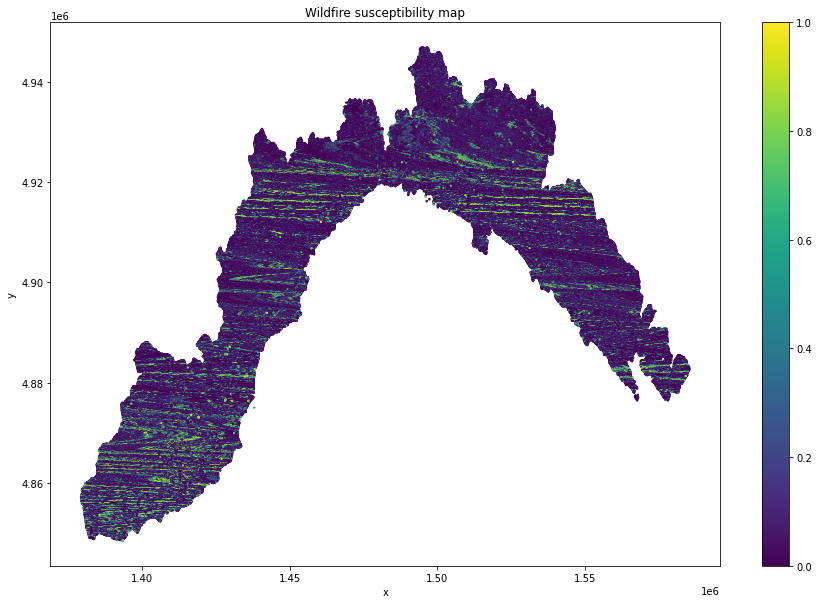

In [128]:
# Scatter x vs y and color the dots with the predicted probability
# to make the susceptibility map 

''' using best model''';

fig, axes = plt.subplots(figsize = (15, 10))
scat = axes.scatter(x, y, c = RF_prob[:, 1], s = 1)
fig.colorbar(scat)
axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Wildfire susceptibility map')

You should get a susceptibility map that looks like the one below. Does your susceptibility map depend on the classifier & the inputs you chose? Which map would you trust most?

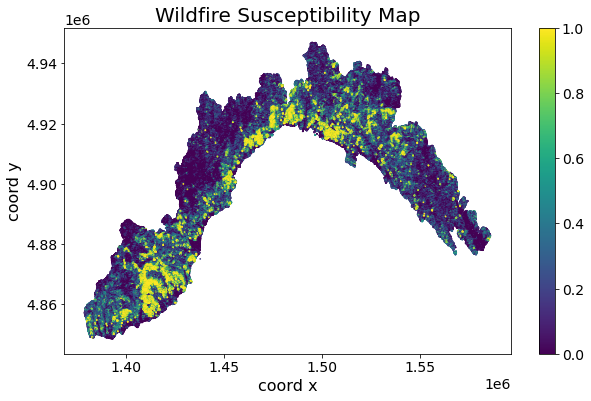

# Bonus Exercise 4: Exploring the Susceptibility Map's Sensitivity to Seasonality and Input Selection

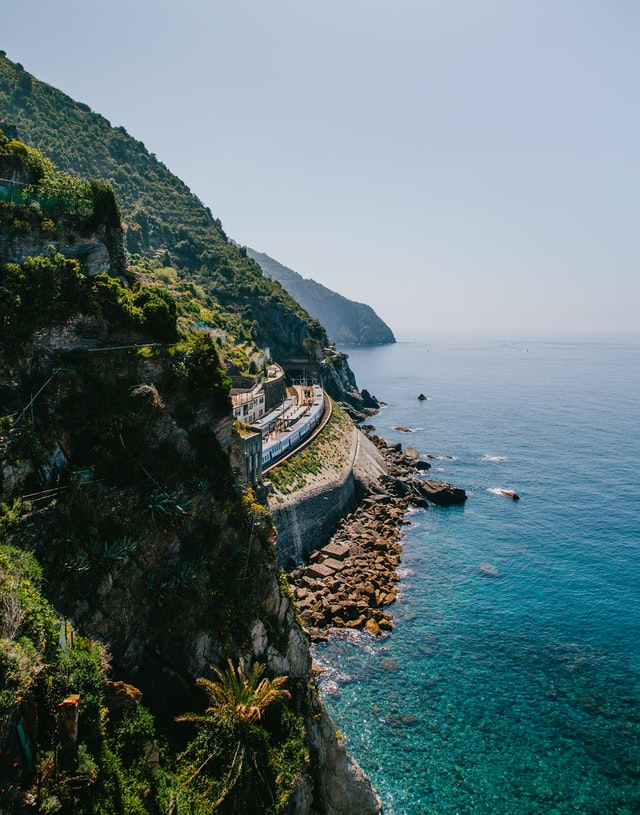

**Caption:** The Liguria region (Cinque Terre), after you save it from raging wildfires using machine learning ✌ 

## Part I: Seasonality

**Q1) Using the `season` column of `wildfires`, separate your data into two seasonal datasets (1=Winter, 2=Summer).**

Hint: When splitting your `inputs` into two seasonal datasets, keep in mind that `temp_1` and `prec_1` are the climatological mean temperatures and precipitation during winter, while `temp_2` and `prec_2` are the climatological mean temperature and precipitation during summer.  

In [ ]:
# Identify indices for which the wildfires occured during winter/summer

In [ ]:
# Use these indices to split your `inputs` and `outputs` datasets 
# into two seasonal datasets

In [ ]:
# Verify that for each season, the shape[0] of your
# `inputs` and `outputs` sets are the same

**Q2) Use these two seasonal datasets to make the Liguria winter and summer susceptibility maps using your best classifier(s). What do you notice?**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# So

In [ ]:
# Much

In [ ]:
# Recycling

In [ ]:
# Compare the winter and summer susceptibility maps

## Part II: Input Selection

The details of the susceptibility map may strongly depend on the inputs you chose from the `variables` dataset. Here, we explore two different ways of selecting inputs to make our susceptibility maps as robust as possible.

**Q3) Using your best classifier, identify the inputs contributing the most to your model's performance using [permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html).**

Hint: You may use `scikit-learn`'s [`permutation_importance` function](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) using your best classifier as your `estimator`.

In [ ]:
# Import the necessary functions and classes

In [ ]:
# Calculate the permutation importance of each of your model's inputs

In [ ]:
# Display the result and identify the most important inputs

**Q4) Retrain the same type of classifier only using the inputs you identified as most important, and display the new susceptibility map.**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# Lots

In [ ]:
# of

In [ ]:
# recycling

In [ ]:
# Make the new susceptibility map

Can you explain the differences in susceptibility maps based on the inputs' spatial distribution?

If the susceptibility map changed a lot, our best classifier may initially have learned spurious correlations. This would have affected our permutation feature importance analysis, and motivates re-selecting our inputs from scratch! 🔨

**Q5) Use the [`SequentialFeatureSelector`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to select the most important inputs. Select as few as possible!**

Hint: Track how the score improves as you add more and more inputs via `n_features_to_select`, and stop when it's "good enough".

In [ ]:
# Import the SequentialFeatureSelector

In [ ]:
# Add more and more inputs

In [ ]:
# How many inputs do you need to get a "good enough" score?

Which inputs have you identified as the most important? Are they the same as the ones you selected using permutation feature importance?

**Q6) Retrain the same type of classifier using as little inputs as possible, and display the new susceptibility map.**

Hint: Feel free to recycle as much code as you can from [the previous exercise](#previous_ex). For instance, you may build a library of functions that directly train the classifier(s) and output susceptibility maps!

In [ ]:
# Recycle your previous code here

In [ ]:
# and here

In [ ]:
# And remake the final susceptibility map

How does it compare to the authors' susceptibility map below?

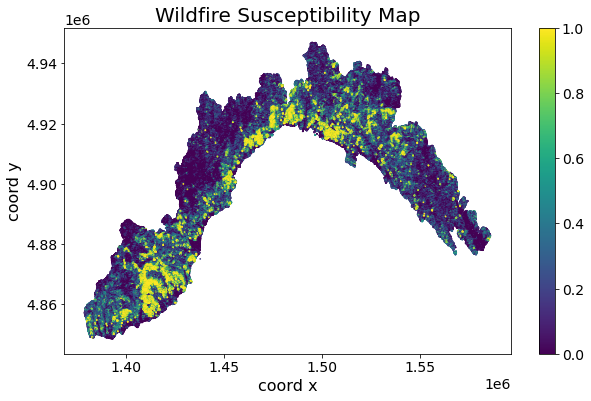